<a href="https://colab.research.google.com/github/ngohuy1811/AIO_Module_6/blob/main/RNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn

seed = 1
torch .manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk


In [5]:
!pip install unidecode
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 59.0MB/s]


In [6]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


In [7]:
dataset_path = '/content/dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding ='ISO-8859-1'

)

In [9]:
classes = {
    class_name: idx for idx , class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [10]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = re.sub(r'[^\w\s]','', text)
    text = ' '.join([word for word in text.split (' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split (' ')])
    return text

In [11]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [12]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [13]:
def transform(text , word_to_idx , max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx ['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']]*(max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    return tokens


In [14]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,  # Ensure `seed` is defined beforehand
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,  # Change to `test_size` as it’s likely meant for testing
    random_state=seed,
    shuffle=is_shuffle
)

In [15]:
class FinancialNews(Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        text = torch.tensor(text)

        return text, label

In [16]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [17]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [18]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

In [21]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}")

    return train_losses, val_losses


def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc


train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print("Evaluation on val/test dataset")
print("Val accuracy:", val_acc)
print("Test accuracy:", test_acc)

EPOCH 1:	Train loss: 1.0049	Val loss: 0.9591
EPOCH 2:	Train loss: 0.9462	Val loss: 0.9344
EPOCH 3:	Train loss: 0.9361	Val loss: 0.9299
EPOCH 4:	Train loss: 0.9320	Val loss: 0.9289
EPOCH 5:	Train loss: 0.9316	Val loss: 0.9285
EPOCH 6:	Train loss: 0.9305	Val loss: 0.9282
EPOCH 7:	Train loss: 0.9274	Val loss: 0.9281
EPOCH 8:	Train loss: 0.9307	Val loss: 0.9281
EPOCH 9:	Train loss: 0.9286	Val loss: 0.9280
EPOCH 10:	Train loss: 0.9340	Val loss: 0.9281
EPOCH 11:	Train loss: 0.9317	Val loss: 0.9282
EPOCH 12:	Train loss: 0.9353	Val loss: 0.9279
EPOCH 13:	Train loss: 0.9335	Val loss: 0.9280
EPOCH 14:	Train loss: 0.9363	Val loss: 0.9279
EPOCH 15:	Train loss: 0.9261	Val loss: 0.9278
EPOCH 16:	Train loss: 0.9285	Val loss: 0.9279
EPOCH 17:	Train loss: 0.9348	Val loss: 0.9282
EPOCH 18:	Train loss: 0.9327	Val loss: 0.9276
EPOCH 19:	Train loss: 0.9350	Val loss: 0.9275
EPOCH 20:	Train loss: 0.9282	Val loss: 0.9276
EPOCH 21:	Train loss: 0.9353	Val loss: 0.9277
EPOCH 22:	Train loss: 0.9292	Val loss: 0.92

# **Hourly Temperature Forecasting**

In [23]:
import torch
import torch.nn as nn

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Importing additional libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [24]:
!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 165MB/s]


In [25]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
  inflating: dataset/weatherHistory.csv  


In [26]:
dataset_filepath = '/content/dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

In [27]:
univariate_df = df['Temperature (C)']
univariate_df.index = pd.to_datetime(df['Formatted Date'])

<ipython-input-27-4f54b223719a>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  univariate_df.index = pd.to_datetime(df['Formatted Date'])


In [28]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [29]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2

train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [30]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [31]:
train_dataset = WeatherForecast(
    X_train, y_train
)
val_dataset = WeatherForecast(
    X_val, y_val
)
test_dataset = WeatherForecast(
    X_test, y_test
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [32]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]  # Extract the last output from the RNN
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [33]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [34]:
lr = 1e-3  # Learning rate
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [35]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 126.5261	Val loss: 40.6979
EPOCH 2:	Train loss: 29.9595	Val loss: 7.4822
EPOCH 3:	Train loss: 16.1813	Val loss: 3.5673
EPOCH 4:	Train loss: 13.1765	Val loss: 3.0718
EPOCH 5:	Train loss: 11.5970	Val loss: 2.0178
EPOCH 6:	Train loss: 10.7809	Val loss: 2.3695
EPOCH 7:	Train loss: 10.0049	Val loss: 2.7381
EPOCH 8:	Train loss: 9.5437	Val loss: 2.0497
EPOCH 9:	Train loss: 9.4036	Val loss: 1.8293
EPOCH 10:	Train loss: 9.0557	Val loss: 1.9996
EPOCH 11:	Train loss: 9.0126	Val loss: 1.5838
EPOCH 12:	Train loss: 8.7332	Val loss: 1.8631
EPOCH 13:	Train loss: 8.6026	Val loss: 1.9579
EPOCH 14:	Train loss: 8.3403	Val loss: 1.6885
EPOCH 15:	Train loss: 8.2734	Val loss: 1.9796
EPOCH 16:	Train loss: 8.0663	Val loss: 2.1195
EPOCH 17:	Train loss: 7.8379	Val loss: 1.6398
EPOCH 18:	Train loss: 7.7163	Val loss: 1.6172
EPOCH 19:	Train loss: 7.6191	Val loss: 1.6292
EPOCH 20:	Train loss: 7.4775	Val loss: 1.8229
EPOCH 21:	Train loss: 7.3221	Val loss: 1.6151
EPOCH 22:	Train loss: 7.1017	Val l

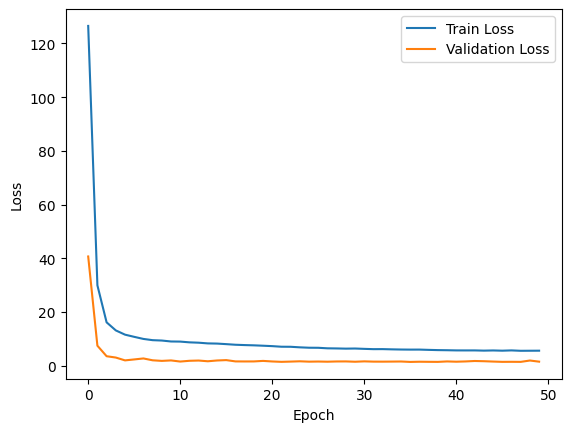

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print("Evaluation on val/test dataset")
print("Val loss:", val_loss)
print("Test loss:", test_loss)

Evaluation on val/test dataset
Val loss: (1.5434581463844523, 0.005391394504924832)
Test loss: (1.3666194923376642, 0.006639692914202718)


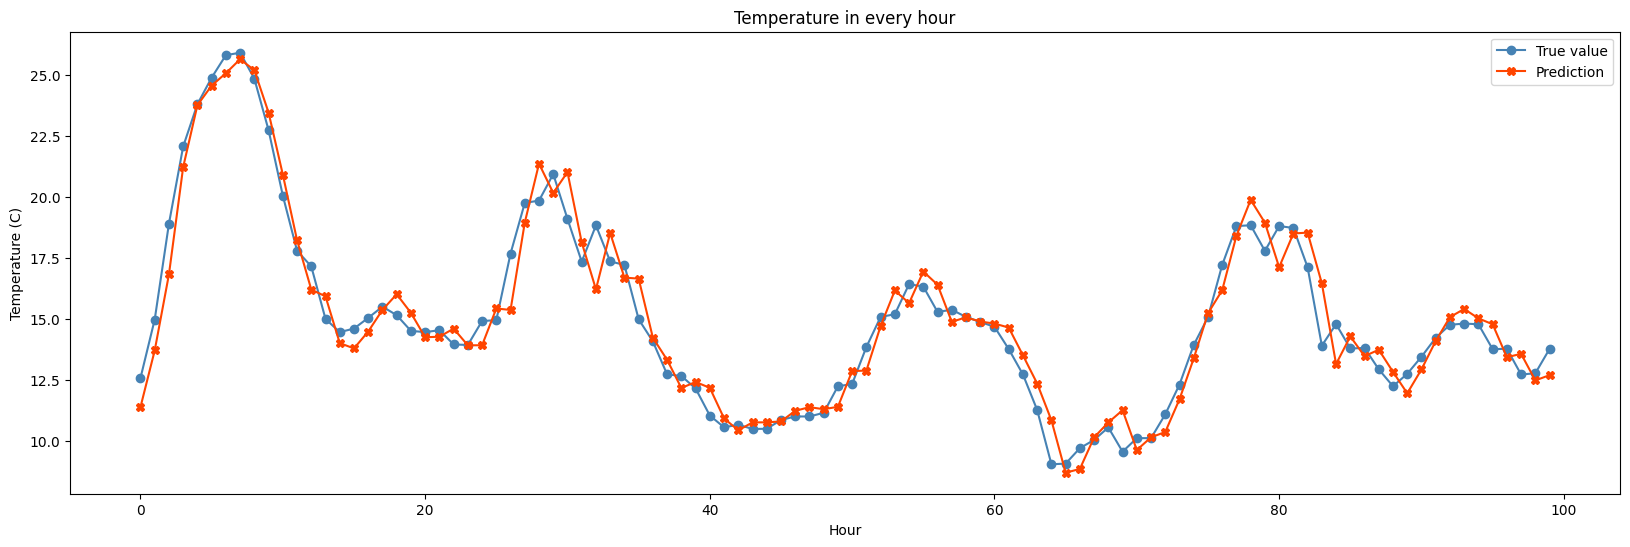

In [38]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hour')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)